In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from helper.lazy_regression import TooLazyForRegression
from helper.feature_extract import extract_highest_amplitude_features_with_mp
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Import data
df_mpa = pd.read_table('../data/data_mpa.txt', sep=' ')
df_mpa = extract_highest_amplitude_features_with_mp(df=df_mpa, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_mpa = df_mpa[df_mpa['start_time'].str.contains('2021')]
df_mpa = df_mpa.drop(["start_time","packnr","velocity"], axis=1)
df_spg = pd.read_table('../data/data_spg.txt', sep=' ')
df_spg = extract_highest_amplitude_features_with_mp(df=df_spg, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_spg = df_spg[df_spg['start_time'].str.contains('2021')]
df_spg = df_spg.drop(["start_time","packnr","velocity"], axis=1)
df_sps = pd.read_table('../data/data_sps.txt', sep=' ')
df_sps = extract_highest_amplitude_features_with_mp(df=df_sps, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_sps = df_sps[df_sps['start_time'].str.contains('2021')]
df_sps = df_sps.drop(["start_time","packnr","velocity"], axis=1)

INFO || Extracting Max Features for types: ['M02', 'M01', 'M03', 'M04']
INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['M01']
INFO || Extracting Max Features for types: ['S01']


In [18]:
X, y = df_mpa.drop(['size_mm'], axis=1), df_mpa['size_mm']
y =y.astype(np.str)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 102)

In [19]:
model= xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

R2-Score: 0.6586394279843288


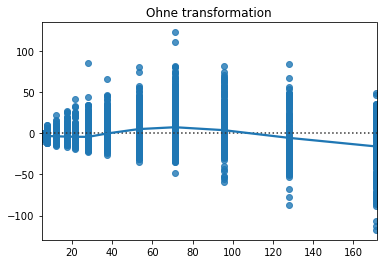

In [20]:
print("R2-Score:",r2_score(y_pred,y_test))
sns.residplot(x=y_test.to_numpy().astype(np.float),y=y_pred,lowess=True)
plt.title("Ohne transformation")
plt.show()

In [13]:
X, y = df_mpa.drop(['size_mm'], axis=1), np.log(df_mpa['size_mm'])
y =y.astype(np.str)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 102)

In [14]:
model= xgb.XGBRegressor()
model.fit(X_train, y_train)
y_test_exp = np.exp(y_test.to_numpy().astype(np.float))
y_pred_exp = np.exp(y_pred)

R2-Score: 0.6227493475892463


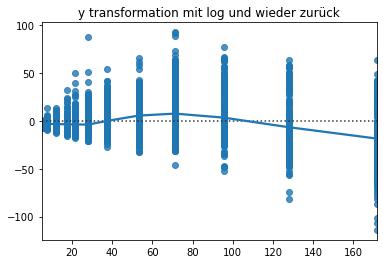

In [16]:
print("R2-Score:",r2_score(y_pred_exp,y_test_exp))
sns.residplot(x=y_test_exp,y=y_pred_exp,lowess=True)
plt.title("y transformation mit log und wieder zurück")
plt.show()

In [24]:
res = y_test.to_numpy().astype(np.float)-y_pred

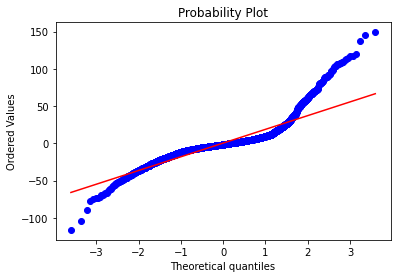

In [26]:
import numpy as np 
import pylab 
import scipy.stats as stats


stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

In [50]:
list(X_test.columns)

['max_centroid_frequency_M',
 'max_centroid_frequency2_M',
 'max_median_freq_M',
 'max_flash_ind_M',
 'max_cv_M',
 'max_iqa_M',
 'max_mab_M',
 'max_imp_M',
 'max_len_M']

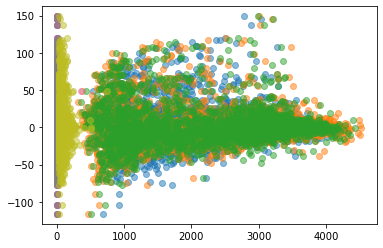

In [91]:
plt.plot(X_test,res,"o",alpha =  0.5)
plt.hlines(y=0,xmin=0, xmax=len(X_test),color="r")
plt.show()

In [4]:
def model_scorer(folds,X,y,X_transformer = None,y_transformer = None):
    all_cols = X.columns
    cols = (X.loc[:, X.columns.str.contains('freq')]).columns
    box_list = [x for x in all_cols if x not in cols]
    if X_transformer == "log":
        X = np.log1p(X)
        X[cols] = np.exp(X[cols])-1      
    if X_transformer == "square_root":
        X = X**(1/2)
        X[cols] = X[cols]**(2/1)     
    if X_transformer == "reciprocal":
        X = 1/X
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        X[cols] = X[cols]**-1
        X.fillna(0)
    if X_transformer == "box_cox":
        for col in box_list:
            X[col], lam = boxcox(np.abs(X[col].replace(0, np.NaN)))
        X.fillna(0)
    if X_transformer == "yeo_johnson":
        for col in box_list:
            X[col], lam = yeojohnson(X[col])
        
    
    
    if y_transformer == "log":
        y = np.log1p(y)
        y =y.astype(np.str)
    if y_transformer == "square_root":
        y =  y**(1/2)
        y =y.astype(np.str)
    if y_transformer == "reciprocal":
        y =  1/y   
        y =y.astype(np.str)
    if y_transformer == "box_cox":
        y, lam_y = boxcox(y)
    
    
    scores = []

    for i in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
        model= xgb.XGBRegressor()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if y_transformer == "log":
            y_pred = np.exp(y_pred)-1
            y_test = np.exp(y_test.to_numpy().astype(np.float))-1
        if y_transformer == "square_root":
            y_pred = y_pred**(2/1)
            y_test = (y_test.to_numpy().astype(np.float))**(2/1)
        if y_transformer == "reciprocal":
            y_pred = y_pred**-1
            y_test = (y_test.to_numpy().astype(np.float))**-1
        if y_transformer == "box_cox":
            y_pred = inv_boxcox(y_pred,lam_y)
            y_test = inv_boxcox(y_test,lam_y)
            
        r2 = r2_score(y_pred,y_test)
        scores.append(r2)
        
    return scores
    

In [5]:
def to_df(liste,name):
    df_trans = pd.DataFrame(liste)
    df_trans["transformation"] = name
    return df_trans

# MPA

In [6]:
X, y = df_mpa.drop(['size_mm'], axis=1), df_mpa['size_mm']
fold = 10

none_trans = model_scorer(folds=fold,X=X,y=y)
log_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "log")
square_root_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "square_root")
reciprocal_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "reciprocal")
box_cox_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "box_cox")
X, y = df_mpa.drop(['size_mm'], axis=1), df_mpa['size_mm']
yeo_johnson_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "yeo_johnson")

In [7]:
df_none_trans = to_df(none_trans,"None")
df_log_trans = to_df(log_trans,"log")
df_square_root_trans = to_df(square_root_trans,"square_root")
df_reciprocal_trans = to_df(reciprocal_trans,"reciprocal")
df_box_cox_trans = to_df(box_cox_trans,"box_cox")
df_yeo_johnson_trans = to_df(yeo_johnson_trans,"yeo_johnson")

In [8]:
dfs = [df_none_trans,df_log_trans,df_square_root_trans,df_reciprocal_trans,df_box_cox_trans,df_yeo_johnson_trans]
result = pd.concat(dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

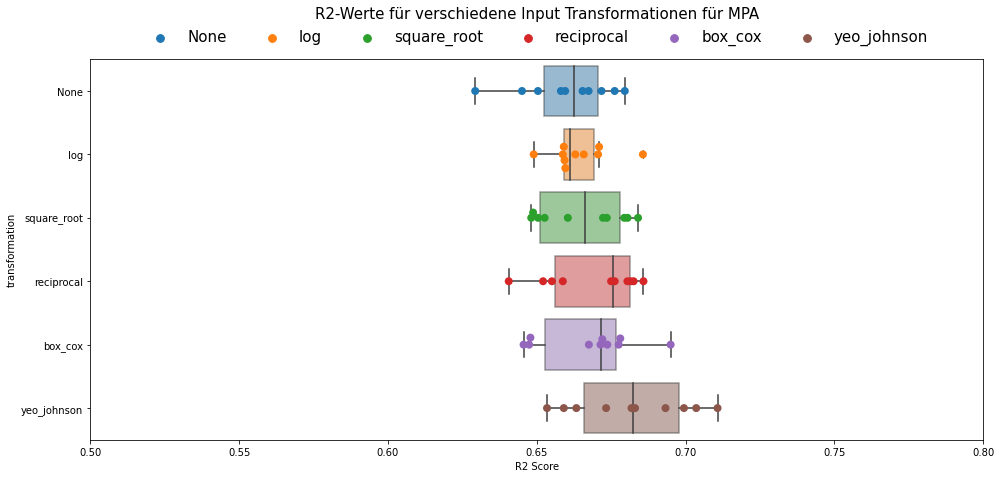

In [9]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Input Transformationen für MPA\n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.8])
plt.show()

In [10]:
X, y = df_mpa.drop(['size_mm'], axis=1), df_mpa['size_mm']
fold = 10

none_trans = model_scorer(folds=fold,X=X,y=y)
log_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "log")
square_root_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "square_root")
reciprocal_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "reciprocal")
box_cox_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "box_cox")

In [11]:
df_none_trans = to_df(none_trans,"None")
df_log_trans = to_df(log_trans,"log")
df_square_root_trans = to_df(square_root_trans,"square_root")
df_reciprocal_trans = to_df(reciprocal_trans,"reciprocal")
df_box_cox_trans = to_df(box_cox_trans,"box_cox")
df_yeo_johnson_trans = to_df(yeo_johnson_trans,"yeo_johnson")

In [12]:
dfs = [df_none_trans,df_log_trans,df_square_root_trans,df_reciprocal_trans,df_box_cox_trans]
result = pd.concat(dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

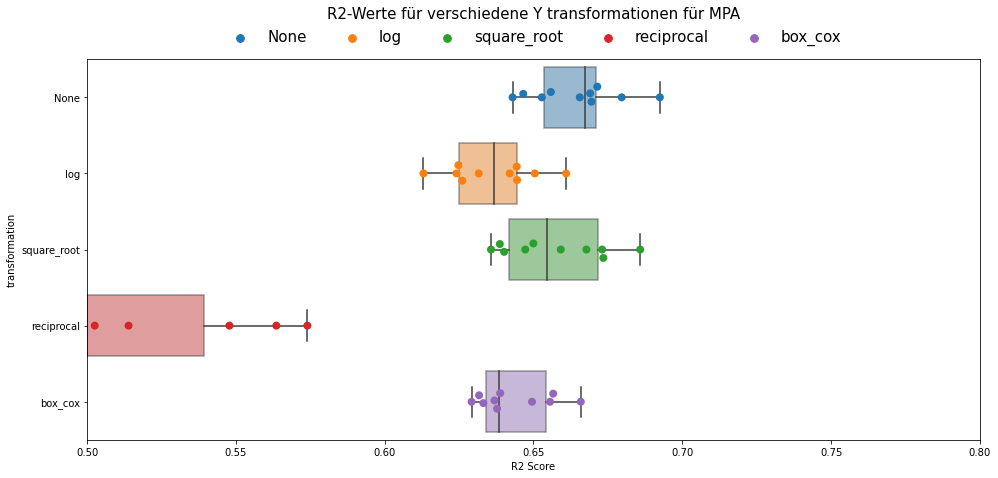

In [14]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Y transformationen für MPA\n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.8])
plt.show()

# SPG

In [15]:
X, y = df_spg.drop(['size_mm'], axis=1), df_spg['size_mm']
fold = 10

none_trans = model_scorer(folds=fold,X=X,y=y)
log_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "log")
square_root_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "square_root")
reciprocal_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "reciprocal")
box_cox_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "box_cox")
X, y = df_spg.drop(['size_mm'], axis=1), df_spg['size_mm']
yeo_johnson_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "yeo_johnson")

In [16]:
df_none_trans = to_df(none_trans,"None")
df_log_trans = to_df(log_trans,"log")
df_square_root_trans = to_df(square_root_trans,"square_root")
df_reciprocal_trans = to_df(reciprocal_trans,"reciprocal")
df_box_cox_trans = to_df(box_cox_trans,"box_cox")
df_yeo_johnson_trans = to_df(yeo_johnson_trans,"yeo_johnson")

In [17]:
dfs = [df_none_trans,df_log_trans,df_square_root_trans,df_reciprocal_trans,df_box_cox_trans,df_yeo_johnson_trans]
result = pd.concat(dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

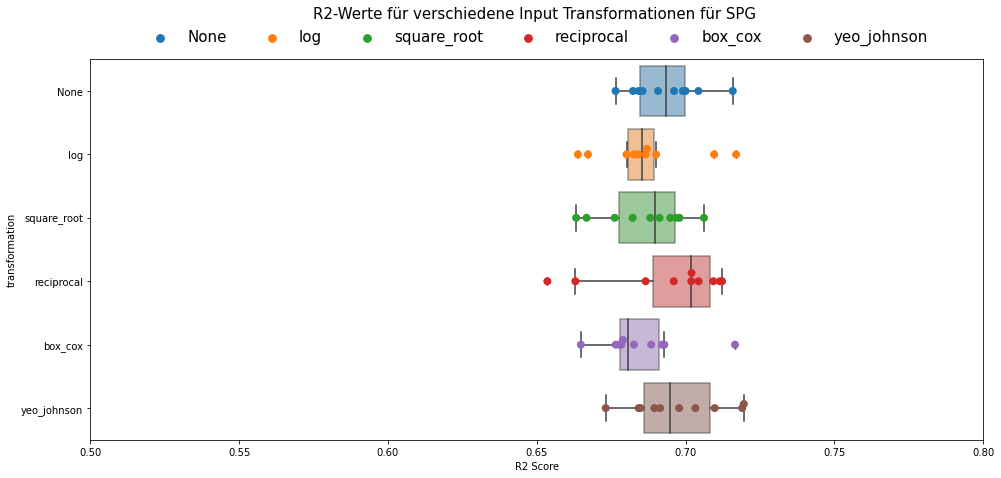

In [18]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Input Transformationen für SPG \n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.8])
plt.show()

In [19]:
X, y = df_spg.drop(['size_mm'], axis=1), df_spg['size_mm']
fold = 10

none_trans = model_scorer(folds=fold,X=X,y=y)
log_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "log")
square_root_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "square_root")
reciprocal_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "reciprocal")
box_cox_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "box_cox")

In [20]:
df_none_trans = to_df(none_trans,"None")
df_log_trans = to_df(log_trans,"log")
df_square_root_trans = to_df(square_root_trans,"square_root")
df_reciprocal_trans = to_df(reciprocal_trans,"reciprocal")
df_box_cox_trans = to_df(box_cox_trans,"box_cox")
df_yeo_johnson_trans = to_df(yeo_johnson_trans,"yeo_johnson")

In [21]:
dfs = [df_none_trans,df_log_trans,df_square_root_trans,df_reciprocal_trans,df_box_cox_trans]
result = pd.concat(dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

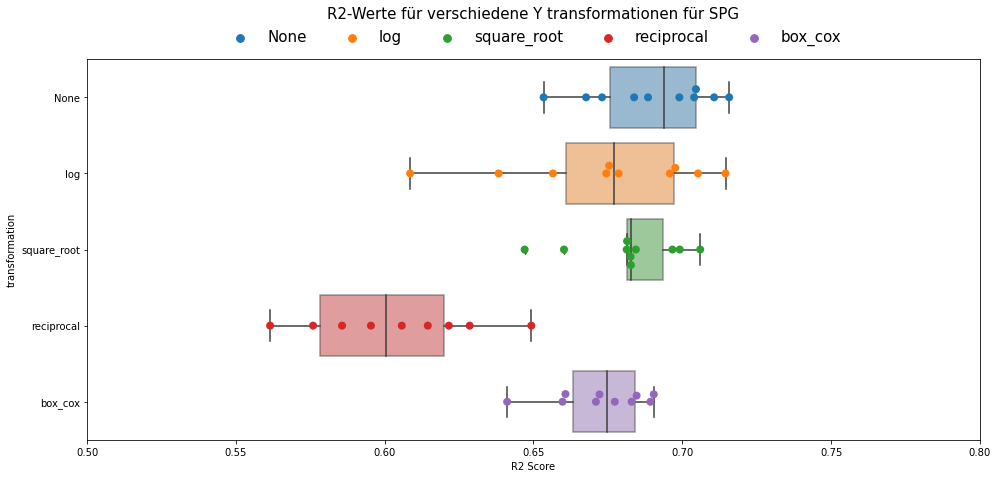

In [22]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Y transformationen für SPG\n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.8])
plt.show()

# SPS

In [23]:
X, y = df_sps.drop(['size_mm'], axis=1), df_sps['size_mm']
fold = 10

none_trans = model_scorer(folds=fold,X=X,y=y)
log_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "log")
square_root_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "square_root")
reciprocal_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "reciprocal")
box_cox_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "box_cox")
X, y = df_sps.drop(['size_mm'], axis=1), df_sps['size_mm']
yeo_johnson_trans = model_scorer(folds=fold,X=X,y=y,X_transformer = "yeo_johnson")

In [24]:
df_none_trans = to_df(none_trans,"None")
df_log_trans = to_df(log_trans,"log")
df_square_root_trans = to_df(square_root_trans,"square_root")
df_reciprocal_trans = to_df(reciprocal_trans,"reciprocal")
df_box_cox_trans = to_df(box_cox_trans,"box_cox")
df_yeo_johnson_trans = to_df(yeo_johnson_trans,"yeo_johnson")

In [25]:
dfs = [df_none_trans,df_log_trans,df_square_root_trans,df_reciprocal_trans,df_box_cox_trans,df_yeo_johnson_trans]
result = pd.concat(dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

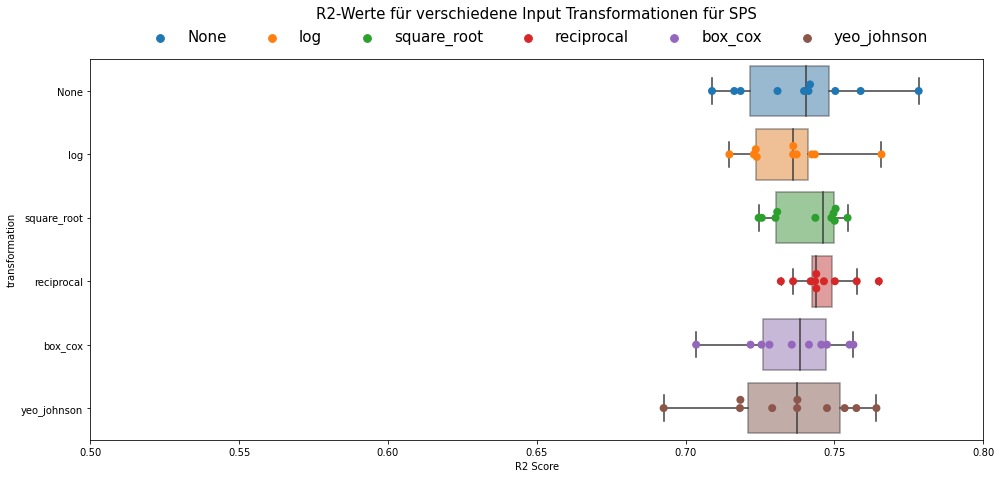

In [26]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Input Transformationen für SPS\n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.8])
plt.show()

In [27]:
X, y = df_sps.drop(['size_mm'], axis=1), df_sps['size_mm']
fold = 10

none_trans = model_scorer(folds=fold,X=X,y=y)
log_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "log")
square_root_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "square_root")
reciprocal_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "reciprocal")
box_cox_trans = model_scorer(folds=fold,X=X,y=y,y_transformer = "box_cox")

In [28]:
df_none_trans = to_df(none_trans,"None")
df_log_trans = to_df(log_trans,"log")
df_square_root_trans = to_df(square_root_trans,"square_root")
df_reciprocal_trans = to_df(reciprocal_trans,"reciprocal")
df_box_cox_trans = to_df(box_cox_trans,"box_cox")
df_yeo_johnson_trans = to_df(yeo_johnson_trans,"yeo_johnson")

In [29]:
dfs = [df_none_trans,df_log_trans,df_square_root_trans,df_reciprocal_trans,df_box_cox_trans]
result = pd.concat(dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

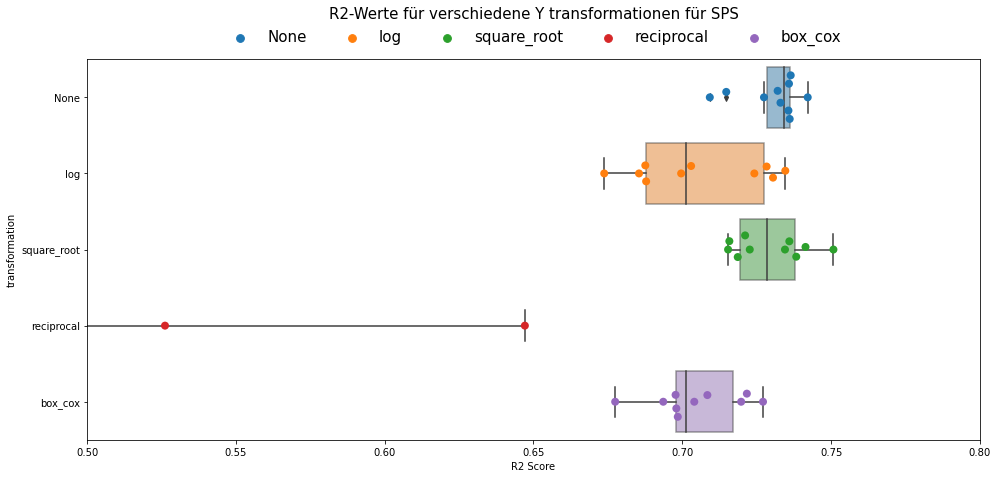

In [30]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Y transformationen für SPS\n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.8])
plt.show()